In [1]:
#uncomment to clean up the variables
%reset -f

In [2]:
#change the folder to your default installation folder
folder = '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc_dev/'

from pyetc_dev import *
import os
import matplotlib.pyplot as plt
from astropy import constants
import skycalc_ipy
from mpdaf.obj import Spectrum
#from astropy import constants

import warnings
warnings.filterwarnings('ignore')

#this is a package of mine for plot quality, comment it and the following row in case you use this notebook 
from setplot import set_plot_style
set_plot_style()

In [3]:
### set up the container
obj = VLT(log = 'DEBUG', skip_dataload = False)

In [22]:
#Obj_SED = template, pl, bb, line

#COADD_WL = binning of the spectral trace, integer

#SED_Name is the name of the template, you can list them with sed_models.eso_spectra_files.keys()

################ only for line #############################
#SPEC_range = fixed, adaptative, None

#### only for fixed ####
#SPEC_HSIZE = 5 [range will be 2 * SPEC_HSIZE + 1]
########################

#### only for adaptative ####
#SPEC_KFWHM = 3 [range will be +- SPEC_KFWHM]
#OPT_SPEC = True, to compute the best SPEC_KFWHM for the maximization of the SNR
#############################
############################################################


#Obj_Spat_Dis = sb, ps, resolved

################ only for resolved ###############################
#IMA = moffat, sersic 

#Ext_Ell = 0.

#### only for moffat ####
#IMA_FWHM = 1. in arcsec
#IMA_BETA = 2.5 in arcsec
#IMA_KFWHM = 3 by default
#########################

#### only for sersic ####
#Sersic_Reff = 1. in arcsec
#Sersic_Ind = 2.
#IMA_KREFF = 6 by default
#########################

##################################################################

################ only for sb ###############################
#IMA_AREA = 1. arcsec, area to use for the SNR computation
#! ! ! substituted by the COADD_XY: number of spaxel per size directly
############################################################

################ only for ps and resolved ##################
#IMA_RANGE = circular_adaptative, square_fixed

#### only for square_fixed ####
#IMA_HSIZE = 5 [range will be 2 * IMA_HSIZE + 1] #INTEGER ! ! ! substituted by the COADD_XY: number of 
#spaxel per size directly
###############################

#### only for circular_adaptative ####
#IMA_KFWHM = 3 [range will be +- IMA_KFWHM]
#OPT_IMA = True, to compute the best IMA_KFWHM for the maximization of the SNR
######################################
############################################################

### "SKYCALC": if false it uses the default configurations in the folder using MOON, 
###true it computes the sky with a call to the ESO Skycalc and want the FLI and PWV parameters

# SNR & Lam_Ref are the target SNR at a specific wave if you want to compute the NDIT or DIT

# OBJ_FIB_DISP is the displacement needed in arcsec, used only in the MOS case (0 for no displacement), 
# could be None for IFS

#Here an example of how it should be

full_obs = {
    "INS": "ifs",
    "CH": "red",
    
    "NDIT": 1,
    "DIT": 1800, 
    
    "SNR": 80,
    "Lam_Ref":5500,
    
    "OBJ_FIB_DISP": 0,
    
    "MOON": 'greysky',
    "PWV": 10,
    "MFLI": 1,
    "SEE": 0.8,
    "AM": 1.16,
    "SKYCALC": True,
    
    "Obj_SED": 'bb',
    "SED_Name": 'Pickles_K7V',
    
    "OBJ_MAG": 18,
    "MAG_SYS": 'Vega',
    "MAG_FIL": 'R',
    
    "Z": 0,
    "BB_Temp": 9000.,
    "PL_Index": None,
    
    "SEL_FLUX": 50e-16,
    "SEL_CWAV": 6000,
    "SEL_FWHM":-2,
    
    "Obj_Spat_Dis": 'ps',
    
    "IMA": 'moffat',
    "Ext_Ell": 0.,
    
    "IMA_FWHM": 1,
    "IMA_BETA": 999,
    "IMA_KFWHM": 5,
    
    "Sersic_Reff": 8.00,
    "Sersic_Ind": 4.00,
    "IMA_KREFF": 5,
    
    "SPEC_RANGE": 'fixed',
    "SPEC_KFWHM": 10,
    "SPEC_HSIZE": int(3601/2),
    
    "COADD_WL": 2,
    
    "IMA_RANGE": 'square_fixed',
    "COADD_XY": 3,
    
    "OPT_SPEC": False,
    "OPT_IMA": False,
    "FRAC_SPEC_MEAN_OPT_IMAGE": 1
}

#"IMA_AREA": (1*0.2)**2,
#"IMA_HSIZE": 1,

ifs blue: wave ≈ 5499.9 Å → FWHM = 0.743 arcsec
ifs red: wave ≈ 5500.0 Å → FWHM = 0.743 arcsec


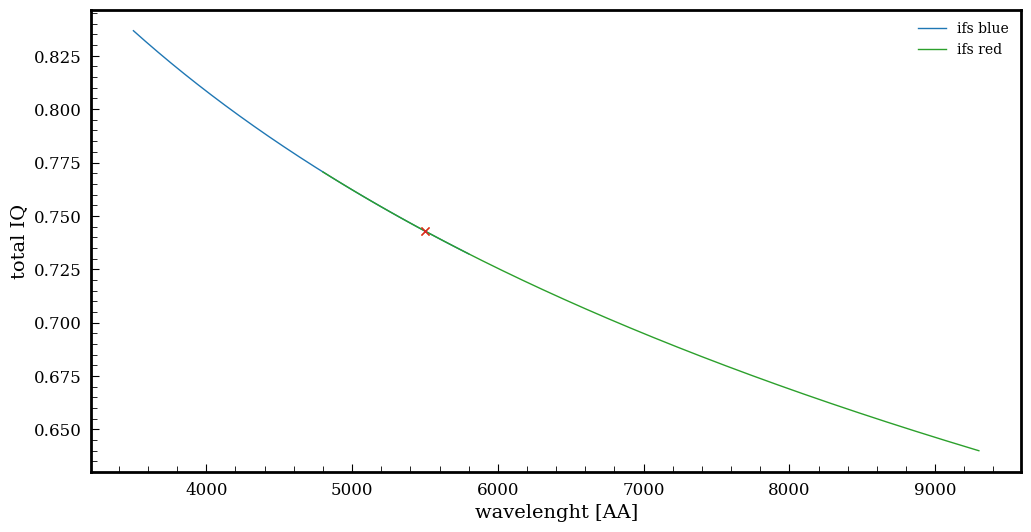

In [23]:
from pyetc_dev.etc import get_seeing_fwhm, show_noise
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

#change this to see how it changes the IQ
#! ! ! QUI A TENTATIVI PER VEDERE CHE SEEING DEVO METTERE NEL MIO DIZIONARIO PER AVERE UNA CERTA IQ_FWHM (TENGO 1)
seeing = full_obs['SEE']
airmass = full_obs['AM']

for ins in [obj.ifs]: #, obj.moshr, obj.moslr]:
    for chan in ins['channels']:
        inst = ins[chan]
        wave = inst['wave'].coord()
        fwhm = get_seeing_fwhm(seeing, airmass, wave, obj.tel['diameter'], inst['iq_fwhm_tel'], inst['iq_fwhm_ins'])[0]
        ax.plot(wave, fwhm, label=f"{inst['name']} {chan}")
        
        #reference wave
        X = 5500.00
        idx = np.argmin(np.abs(wave - X))
        closest_wave = wave[idx]
        fwhm_at_X = fwhm[idx]
        
        ax.plot(closest_wave, fwhm_at_X, marker='x')
        print(f"{inst['name']} {chan}: wave ≈ {closest_wave:.1f} Å → FWHM = {fwhm_at_X:.3f} arcsec")
ax.legend()
ax.set_ylabel('total IQ')
ax.set_xlabel('wavelenght [AA]');

In [24]:
con, ob, spe, im, spe_input = obj.build_obs_full(full_obs)

In [25]:
res_time = obj.time_from_source(con, im, spe, dit=True)

Computing DIT for target SNR: 80
Computed DIT: 2051.70 > 2052.00 for target SNR: 80.00 at wavelength 5500.00 A, in 9 spaxels
% % % Computing fraction of saturated pixels % % %
Fraction of saturated voxels: 0.0% for saturation level 65000.00 counts
[DEBUG] Source type ps & cont
Time elapsed: 0.03 seconds


In [26]:
res_snr = obj.snr_from_source(con, im, spe)

[DEBUG] Computing frac and nspaxels for 20 wavelengths (lbin 20)
[DEBUG] Performing interpolation
[DEBUG] At 4800.0 A  FWHM: 0.77 Flux fraction: 0.41 Aperture: 0.6 Nspaxels: 9
[DEBUG] At 9300.0 A  FWHM: 0.64 Flux fraction: 0.53 Aperture: 0.6 Nspaxels: 9
[DEBUG] Source type ps & cont Flux 1.00e+00 S/N 52.3 FracFlux 0.476 Nspaxels 9 Nspectels 1
[DEBUG] Computing rebinned spectrum for factor 2
Time elapsed: 0.33 seconds


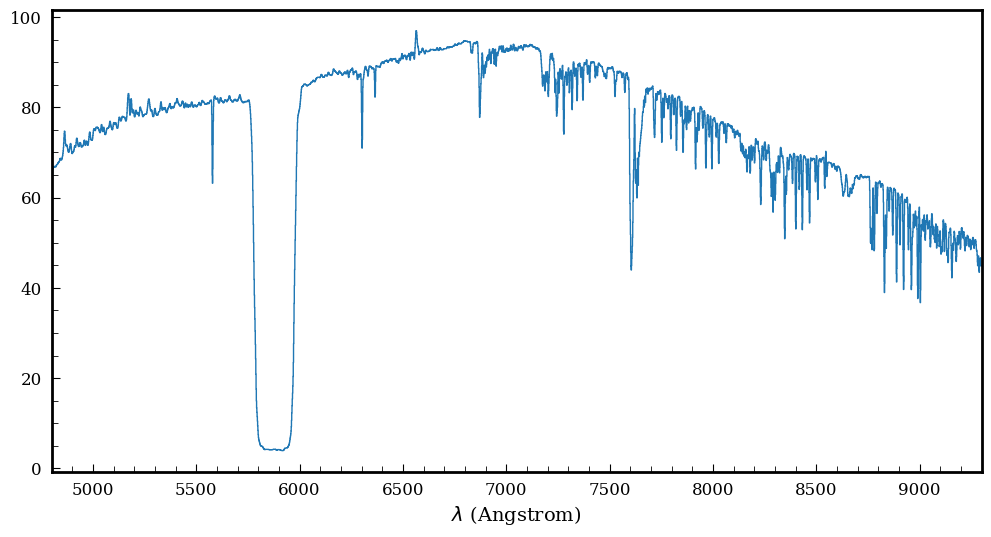

In [27]:
res_snr['spec']['snr_rebin'].plot()

In [ ]:
e_dit = res_snr['spec']['nph_source']
e_dit /= ob['ndit']

In [ ]:
e_dit.plot()